### IMPORTING ALL THE NECESSARY LIBRARIES

In [2]:
import numpy as np
import pandas as pd
import os
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Activation, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
import warnings
import librosa.display
from IPython.display import Audio
import random 
import joblib
from joblib import Parallel, delayed


warnings.filterwarnings('ignore')

2024-07-23 00:21:28.069466: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### EXPLORATORY DATA ANALYSIS AFTER DATA LOADING

In [4]:

ravdess_path = '/Users/manish/FINAL THESIS/Audio_Speech_Actors_01-24'
file_list = os.listdir(ravdess_path)
print(file_list)

['Actor_16', 'Actor_11', 'Actor_18', 'Actor_20', 'Actor_21', 'Actor_19', 'Actor_10', 'Actor_17', '.DS_Store', 'Actor_04', 'Actor_03', 'Actor_02', 'Actor_05', 'Actor_12', 'Actor_15', 'Actor_23', 'Actor_24', 'Actor_22', 'Actor_14', 'Actor_13', 'Actor_09', 'Actor_07', 'Actor_06', 'Actor_01', 'Actor_08']


In [5]:
# Initialize lists to store features and labels
features = []
emotions = []
file_paths = []

In [6]:

emotion_map = {
    1: 'neutral', 2: 'calm', 3: 'happy', 4: 'sad', 5: 'angry', 6: 'fearful', 7: 'disgusted', 8: 'surprised'
}

# Populate the file paths and emotions
for actor in os.listdir(ravdess_path):
    actor_folder = os.path.join(ravdess_path, actor)
    if os.path.isdir(actor_folder):  # Check if it's a directory
        for file_name in os.listdir(actor_folder):
            file_path = os.path.join(actor_folder, file_name)
            emotion = int(file_name.split("-")[2])
            emotions.append(emotion_map[emotion])
            file_paths.append(file_path)

In [7]:
# Create DataFrame 
features_df = pd.DataFrame({'emotion': emotions, 'file_path': file_paths})

print("First and last few rows of the DataFrame:")
print(features_df[['emotion', 'file_path']].head())
print(features_df[['emotion', 'file_path']].tail())






First and last few rows of the DataFrame:
     emotion                                          file_path
0      angry  /Users/manish/FINAL THESIS/Audio_Speech_Actors...
1    fearful  /Users/manish/FINAL THESIS/Audio_Speech_Actors...
2    fearful  /Users/manish/FINAL THESIS/Audio_Speech_Actors...
3      angry  /Users/manish/FINAL THESIS/Audio_Speech_Actors...
4  disgusted  /Users/manish/FINAL THESIS/Audio_Speech_Actors...
      emotion                                          file_path
1435    happy  /Users/manish/FINAL THESIS/Audio_Speech_Actors...
1436    happy  /Users/manish/FINAL THESIS/Audio_Speech_Actors...
1437     calm  /Users/manish/FINAL THESIS/Audio_Speech_Actors...
1438     calm  /Users/manish/FINAL THESIS/Audio_Speech_Actors...
1439  neutral  /Users/manish/FINAL THESIS/Audio_Speech_Actors...


In [8]:
# Checking for missing values
missing_values = features_df.isnull().sum()
print("Missing values in each column:")
print(missing_values)



Missing values in each column:
emotion      0
file_path    0
dtype: int64


In [9]:
print("\nSummary of the DataFrame:")
print(features_df.describe(include='all'))


Summary of the DataFrame:
       emotion                                          file_path
count     1440                                               1440
unique       8                                               1440
top      angry  /Users/manish/FINAL THESIS/Audio_Speech_Actors...
freq       192                                                  1


In [10]:
# Displaying the count of each emotion
emotion_counts = features_df['emotion'].value_counts()
print("\nCount of each emotion:")
print(emotion_counts)



Count of each emotion:
emotion
angry        192
fearful      192
disgusted    192
sad          192
surprised    192
happy        192
calm         192
neutral       96
Name: count, dtype: int64


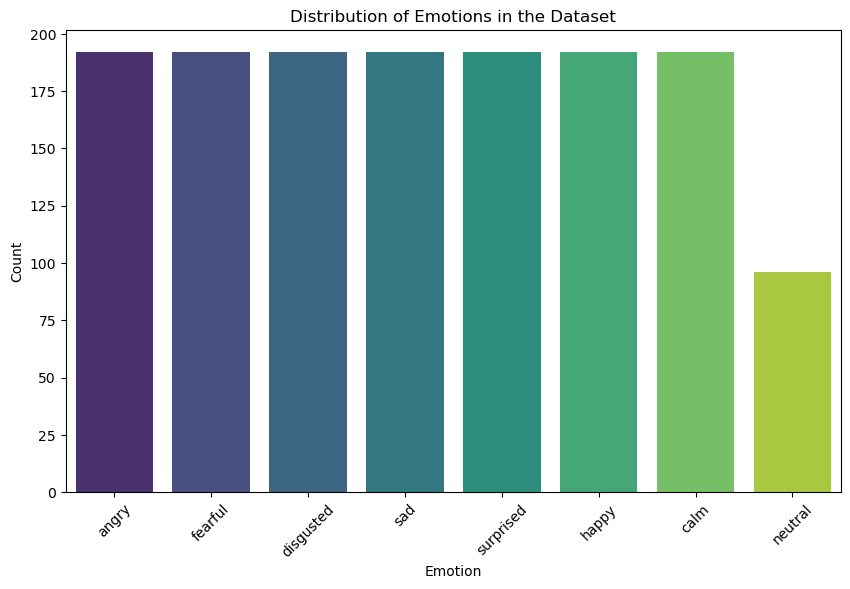

In [11]:
# Plotting the distribution of emotions
plt.figure(figsize=(10, 6))
sns.barplot(x=emotion_counts.index, y=emotion_counts.values, palette='viridis')
plt.title('Distribution of Emotions in the Dataset')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

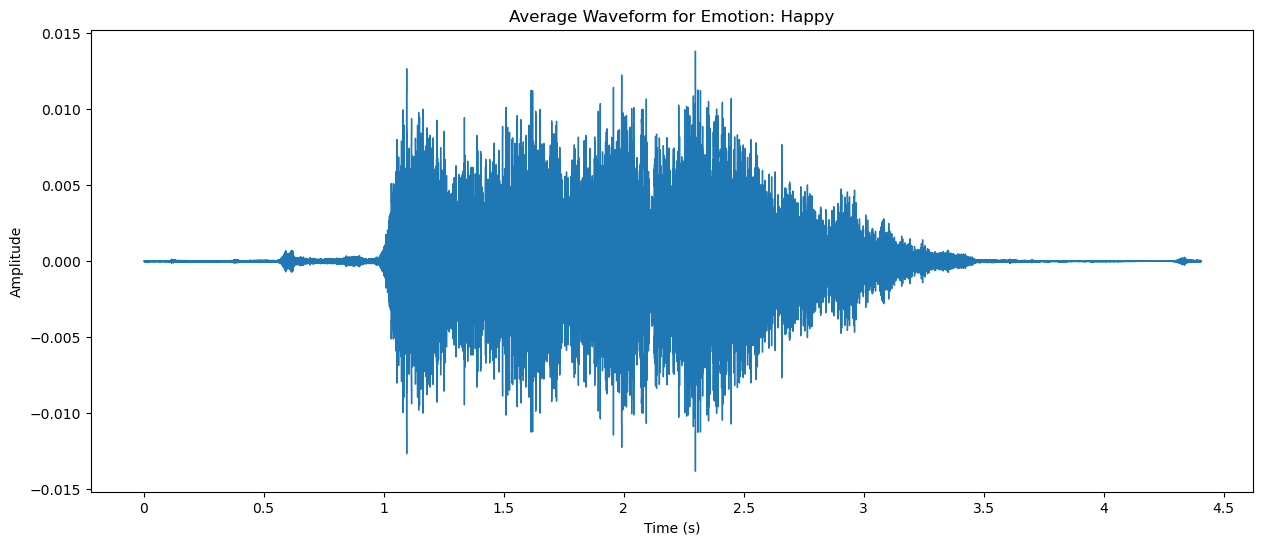

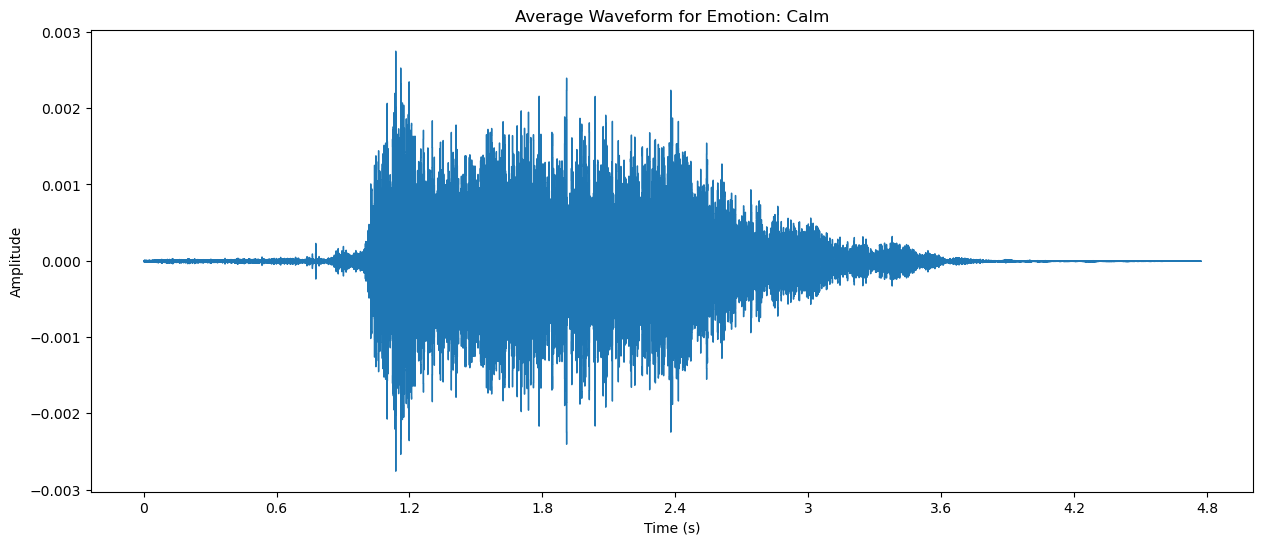

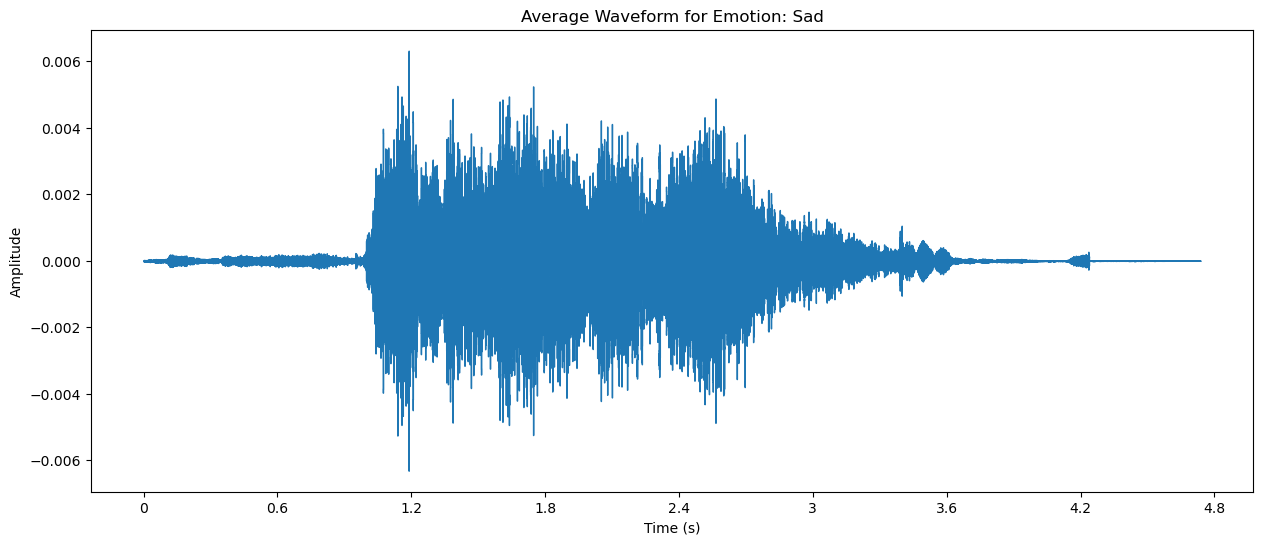

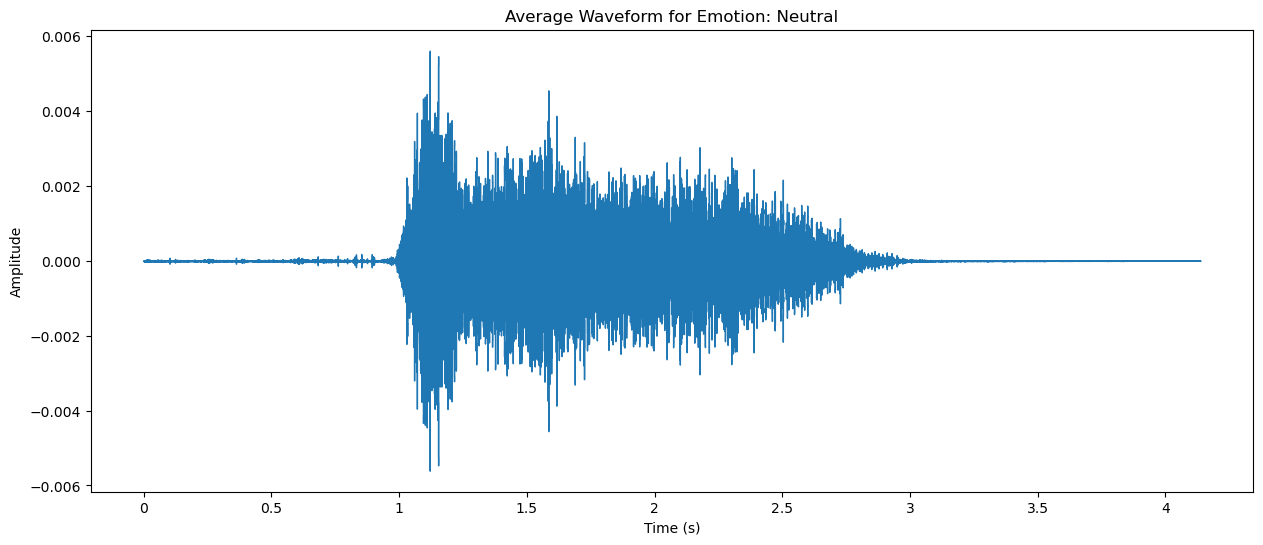

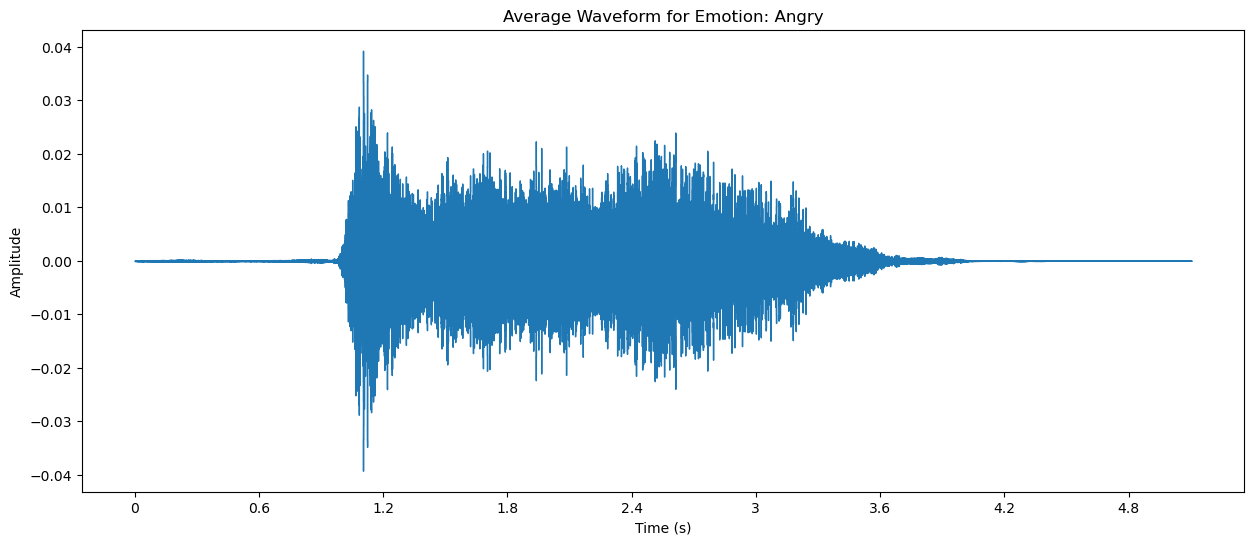

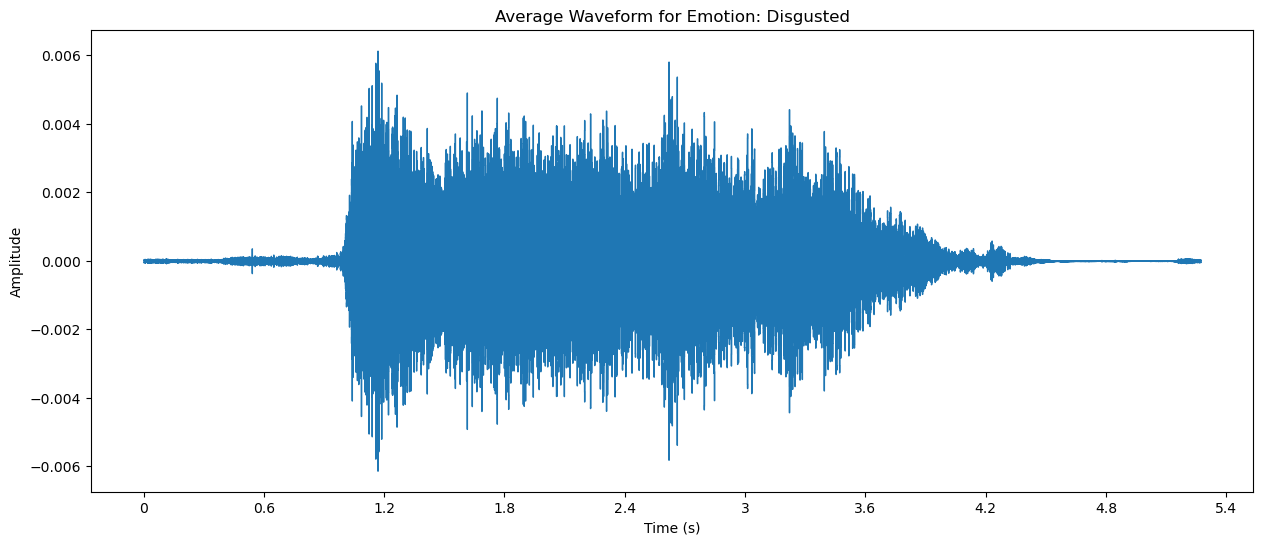

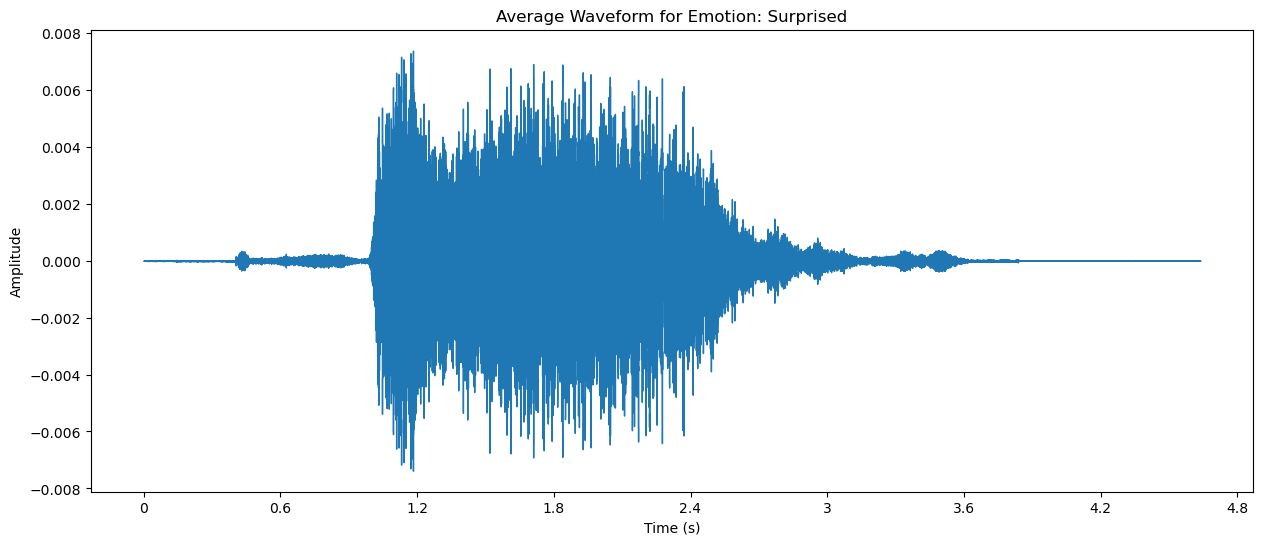

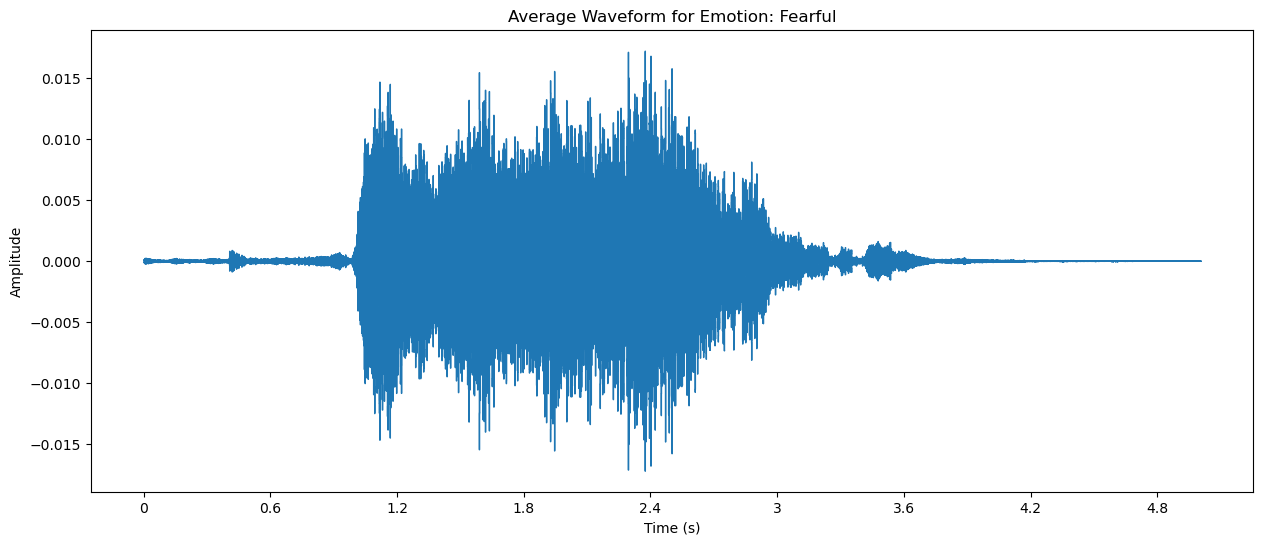

In [12]:

# defining a function to plot average waveform for each emotion and play random sample audio
def plot_and_play_waveform(emotion_label):
    
    subset_df = features_df[features_df['emotion'] == emotion_label]
    
    # Initialize an empty list to store the waveforms
    waveforms = []
    
    # Iterate through the audio files for the emotion and collect the waveforms
    max_length = 0  
    for _, row in subset_df.iterrows():
        file_path = row['file_path']
        audio_data, sr = librosa.load(file_path, sr=None)
        if len(audio_data) > 0:  
            max_length = max(max_length, len(audio_data))  
            waveforms.append(audio_data)
        else:
            print(f"No audio data loaded for file: {file_path}")
    
    if not waveforms:
        print(f"No valid audio files found for emotion: {emotion_label}")
        return
    
    # Padding or truncate waveforms to the maximum length
    for i in range(len(waveforms)):
        if len(waveforms[i]) < max_length:
            waveforms[i] = np.pad(waveforms[i], (0, max_length - len(waveforms[i])), mode='constant')
        elif len(waveforms[i]) > max_length:
            waveforms[i] = waveforms[i][:max_length]
    
    # Calculating the average waveform and then plotting it
    average_waveform = np.mean(np.vstack(waveforms), axis=0)
    
    plt.figure(figsize=(15, 6))
    plt.title(f'Average Waveform for Emotion: {emotion_label.capitalize()}')
    librosa.display.waveshow(average_waveform, sr=sr)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.show()

    # Playing a random sample audio from the subset
    sample_file = random.choice(subset_df['file_path'].tolist())
    audio_data, sr = librosa.load(sample_file)
    return Audio(data=audio_data, rate=sr)


emotions_to_plot = ['happy', 'calm', 'sad', 'neutral', 'angry', 'disgusted', 'surprised', 'fearful']


for emotion in emotions_to_plot:
    audio_player = plot_and_play_waveform(emotion)
    display(audio_player)


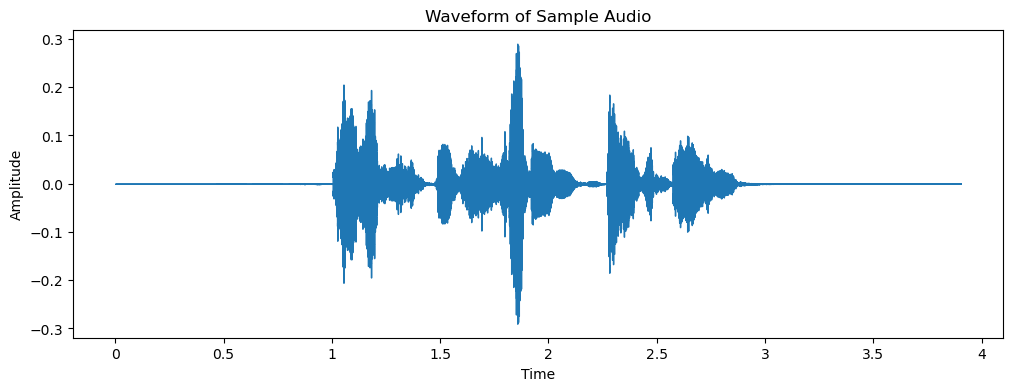

In [13]:
# Loading a sample audio file from the dataset
sample_file = features_df['file_path'].iloc[0]
audio_data, sr = librosa.load(sample_file)

# Plotting the waveform
plt.figure(figsize=(12, 4))
librosa.display.waveshow(audio_data, sr=sr)
plt.title('Waveform of Sample Audio')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

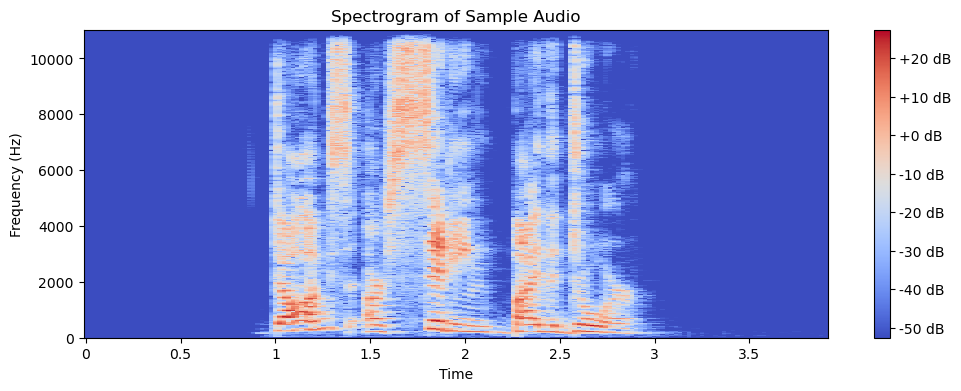

In [14]:
# Plotting the spectrogram
X = librosa.stft(audio_data)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(12, 4))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram of Sample Audio')
plt.xlabel('Time')
plt.ylabel('Frequency (Hz)')
plt.show()

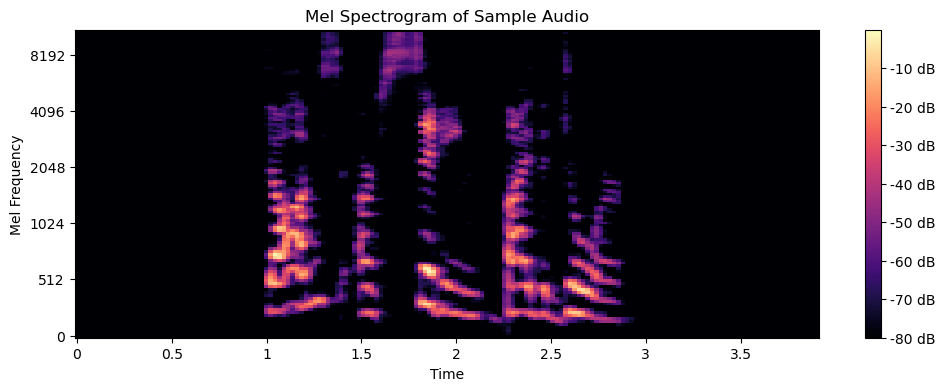

In [15]:
# Plotting the Mel spectrogram
S = librosa.feature.melspectrogram(y=audio_data, sr=sr, n_mels=128)
S_DB = librosa.amplitude_to_db(S, ref=np.max)
plt.figure(figsize=(12, 4))
librosa.display.specshow(S_DB, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram of Sample Audio')
plt.xlabel('Time')
plt.ylabel('Mel Frequency')
plt.show()

## FEATURE EXTRACTION

In [17]:
class FeatureExtractor:
    def __init__(self, frame_length=2048, hop_length=512):
        self.frame_length = frame_length
        self.hop_length = hop_length

    def zcr(self, features_df):
        return librosa.feature.zero_crossing_rate(features_df, frame_length=self.frame_length, hop_length=self.hop_length).flatten()

    def rmse(self, features_df):
        return librosa.feature.rms(y=features_df, frame_length=self.frame_length, hop_length=self.hop_length).flatten()

    def mfcc(self, features_df, sr, n_mfcc=13, flatten=True):
        mfcc_features = librosa.feature.mfcc(y=features_df, sr=sr, n_mfcc=n_mfcc, hop_length=self.hop_length)
        return mfcc_features.T.flatten() if flatten else mfcc_features.T

    def chroma(self, features_df, sr):
        chroma_features = librosa.feature.chroma_stft(y=features_df, sr=sr, hop_length=self.hop_length)
        return chroma_features.T.flatten()

    def spectral_contrast(self, features_df, sr):
        contrast_features = librosa.feature.spectral_contrast(y=features_df, sr=sr, hop_length=self.hop_length)
        return contrast_features.T.flatten()

    def mel_spectrogram(self, features_df, sr):
        mel_features = librosa.feature.melspectrogram(y=features_df, sr=sr, hop_length=self.hop_length)
        return librosa.power_to_db(mel_features).flatten()

    def extract_features(self, features_df, sr):
        zcr_features = self.zcr(features_df)
        rmse_features = self.rmse(features_df)
        mfcc_features = self.mfcc(features_df, sr)
        chroma_features = self.chroma(features_df, sr)
        spectral_contrast_features = self.spectral_contrast(features_df, sr)
        mel_spectrogram_features = self.mel_spectrogram(features_df, sr)
        return np.concatenate([zcr_features,
                                rmse_features,
                                mfcc_features,
                                chroma_features,
                                spectral_contrast_features,
                                mel_spectrogram_features])




## DATA AUGMENTATION

In [19]:
class DataAugmentation:
    @staticmethod
    def noise(features_df, noise_factor=0.005):
        noise_amp = noise_factor * np.random.uniform() * np.amax(features_df)
        return features_df + noise_amp * np.random.normal(size=features_df.shape[0])

    @staticmethod
    def pitch(features_df, sr, n_steps=4):
        return librosa.effects.pitch_shift(y=features_df, sr=sr, n_steps=n_steps)


## AUDIO PROCESSING

In [21]:

class AudioProcessor:
    def __init__(self, frame_length=2048, hop_length=512):
        self.feature_extractor = FeatureExtractor(frame_length, hop_length)
        self.augmenter = DataAugmentation()

    def get_features(self, path, duration=2.5, offset=0.6):
        features_df, sr = librosa.load(path, duration=duration, offset=offset)
        features = [self.feature_extractor.extract_features(features_df, sr)]

        noised_audio = self.augmenter.noise(features_df)
        features.append(self.feature_extractor.extract_features(noised_audio, sr))

        pitched_audio = self.augmenter.pitch(features_df, sr)
        features.append(self.feature_extractor.extract_features(pitched_audio, sr))

        pitched_noised_audio = self.augmenter.noise(pitched_audio)
        features.append(self.feature_extractor.extract_features(pitched_noised_audio, sr))

        return np.array(features)

    def process_feature(self, path, emotion):
        features = self.get_features(path)
        X = features.tolist()
        Y = [emotion] * len(features)
        return X, Y

    def process_dataset(self, df, n_jobs=-1):
        paths = df['file_path'].values
        emotions = df['emotion'].values

        results = Parallel(n_jobs=n_jobs)(delayed(self.process_feature)(path, emotion) for path, emotion in zip(paths, emotions))

        X, Y = [], []
        for result in results:
            X.extend(result[0])
            Y.extend(result[1])


        # Pad or truncate sequences to the same length
        max_len = max(len(x) for x in X)
        X = np.array([np.pad(x, (0, max_len - len(x)), 'constant') if len(x) < max_len else x[:max_len] for x in X])

        return X, np.array(Y)



In [22]:
# Defining a function to process and split the dataset for CNN
def process_and_split_dataset_for_cnn(df):
    
    # Instantiate AudioProcessor
    processor = AudioProcessor()
    X, Y = processor.process_dataset(df)
    print("Processed dataset shapes - X:", X.shape, "Y:", Y.shape)

    # Standardize the features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    joblib.dump(scaler, 'scaler.pkl')

    # Encoding the labels
    encoder = LabelEncoder()
    Y = encoder.fit_transform(Y)
    joblib.dump(encoder, 'label_encoder.pkl')

    num_classes = len(np.unique(Y))
    Y = to_categorical(Y, num_classes=num_classes)

    # Splitting the data into training and testing sets
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

    # Reshaping the data for CNN (adding an extra dimension for channels)
    X_train_CNN = X_train.reshape((X_train.shape[0], X_train.shape[1], 1, 1))
    X_test_CNN = X_test.reshape((X_test.shape[0], X_test.shape[1], 1, 1))

    return X_train, X_test, Y_train, Y_test, num_classes, X_train_CNN, X_test_CNN



In [23]:
#PROCESSED DATA FOR CNN
X_train, X_test, Y_train, Y_test, num_classes, X_train_CNN, X_test_CNN = process_and_split_dataset_for_cnn(features_df)

print("Processed dataset shapes for CNN:")
print("X_train:", X_train_CNN.shape)
print("Y_train:", Y_train.shape)
print("X_test:", X_test_CNN.shape)
print("Y_test:", Y_test.shape)
print("Number of classes:", num_classes)


Processed dataset shapes - X: (5760, 17496) Y: (5760,)
Processed dataset shapes for CNN:
X_train: (4608, 17496, 1, 1)
Y_train: (4608, 8)
X_test: (1152, 17496, 1, 1)
Y_test: (1152, 8)
Number of classes: 8


In [24]:

class FeatureExtractor:
    def __init__(self, frame_length=2048, hop_length=512):
        self.frame_length = frame_length
        self.hop_length = hop_length

    def extract_features(self, y, sr):
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
        return mfccs.T

class AudioProcessor:
    def __init__(self, frame_length=2048, hop_length=512):
        self.feature_extractor = FeatureExtractor(frame_length, hop_length)

    def get_features(self, path, duration=2.5, offset=0.6):
        y, sr = librosa.load(path, duration=duration, offset=offset)
        features = self.feature_extractor.extract_features(y, sr)
        return features

    def process_feature(self, path, emotion):
        features = self.get_features(path)
        return features, emotion

    def process_dataset(self, df, n_jobs=-1):
        paths = df['file_path'].values
        emotions = df['emotion'].values

        results = Parallel(n_jobs=n_jobs)(delayed(self.process_feature)(path, emotion) for path, emotion in zip(paths, emotions))

        X, Y = zip(*results)

        # Find the maximum length for padding
        max_len = max(x.shape[0] for x in X)
        print(f"Max length for padding: {max_len}")

        # Pad sequences to the same length
        X_padded = np.array([np.pad(x, ((0, max_len - x.shape[0]), (0, 0)), mode='constant') if x.shape[0] < max_len else x for x in X])

        return X_padded, np.array(Y)




In [25]:
def process_and_split_dataset_for_lstm(df):
    processor = AudioProcessor()
    X, Y = processor.process_dataset(df)
    print("Processed dataset shapes - X:", X.shape, "Y:", Y.shape)

    # Standardize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)

    # Encoding the labels
    le = LabelEncoder()
    Y_encoded = le.fit_transform(Y)
    num_classes = len(le.classes_)

    # Converting to categorical
    Y_categorical = to_categorical(Y_encoded, num_classes=num_classes)

    # Splitting the data
    X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y_categorical, test_size=0.2, random_state=42)

    return X_train, X_test, Y_train, Y_test, num_classes



In [26]:
#PROCESSED DATA FOR LSTM
X_train_lstm, X_test_lstm, Y_train_lstm, Y_test_lstm, num_classes = process_and_split_dataset_for_lstm(features_df)

print("Processed dataset shapes for LSTM:")
print("X_train:", X_train_lstm.shape)
print("Y_train:", Y_train_lstm.shape)
print("X_test:", X_test_lstm.shape)
print("Y_test:", Y_test_lstm.shape)
print("Number of classes:", num_classes)


Max length for padding: 108
Processed dataset shapes - X: (1440, 108, 40) Y: (1440,)
Processed dataset shapes for LSTM:
X_train: (1152, 108, 40)
Y_train: (1152, 8)
X_test: (288, 108, 40)
Y_test: (288, 8)
Number of classes: 8


## MODEL DEVELOPMENT

## DEEP LEARNING MODELS

## CNN

In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

#CNN model building
def cnn_model(input_shape, num_classes):
    model = Sequential()
    model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', input_shape=input_shape, padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2, 1)))
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2, 1)))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    #model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model




In [38]:
CNN= cnn_model(X_train_CNN.shape[1:], num_classes)
CNN.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 17496, 1, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 8748, 1, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8748, 1, 32)    │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 4374, 1, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 139968)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     8,958,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,963,336 (34.19 MB)

 Trainable params: 8,963,336 (34.19 MB)

 Non-trainable params: 0 (0.00 B)

In [39]:
history= CNN.fit(X_train_CNN, Y_train, epochs = 10, batch_size=32, validation_data = (X_test_CNN, Y_test))

Epoch 1/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 73s 473ms/step - accuracy: 0.3606 - loss: 1.7994 - val_accuracy: 0.6155 - val_loss: 1.0419
Epoch 2/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 82s 478ms/step - accuracy: 0.7543 - loss: 0.7273 - val_accuracy: 0.8247 - val_loss: 0.4765
Epoch 3/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 69s 479ms/step - accuracy: 0.9533 - loss: 0.1900 - val_accuracy: 0.9080 - val_loss: 0.2572
Epoch 4/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 68s 472ms/step - accuracy: 0.9940 - loss: 0.0441 - val_accuracy: 0.9366 - val_loss: 0.2224
Epoch 5/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 70s 488ms/step - accuracy: 0.9982 - loss: 0.0145 - val_accuracy: 0.9401 - val_loss: 0.2080
Epoch 6/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 68s 471ms/step - accuracy: 0.9983 - loss: 0.0057 - val_accuracy: 0.9418 - val_loss: 0.2037
Epoch 7/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 68s 471ms/step - accuracy: 0.9984 - loss: 0.0037 - val_accuracy: 0.9497 - val_loss: 0.1807
Epoch 8/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 69s 480ms/step - accuracy: 1.0000 - loss: 0

In [40]:
#Evaluation of the model
loss, accuracy = CNN.evaluate(X_test_CNN, Y_test)
print(f'CNN Test Accuracy: {accuracy}')


36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 0.9458 - loss: 0.1853
CNN Test Accuracy: 0.9453125


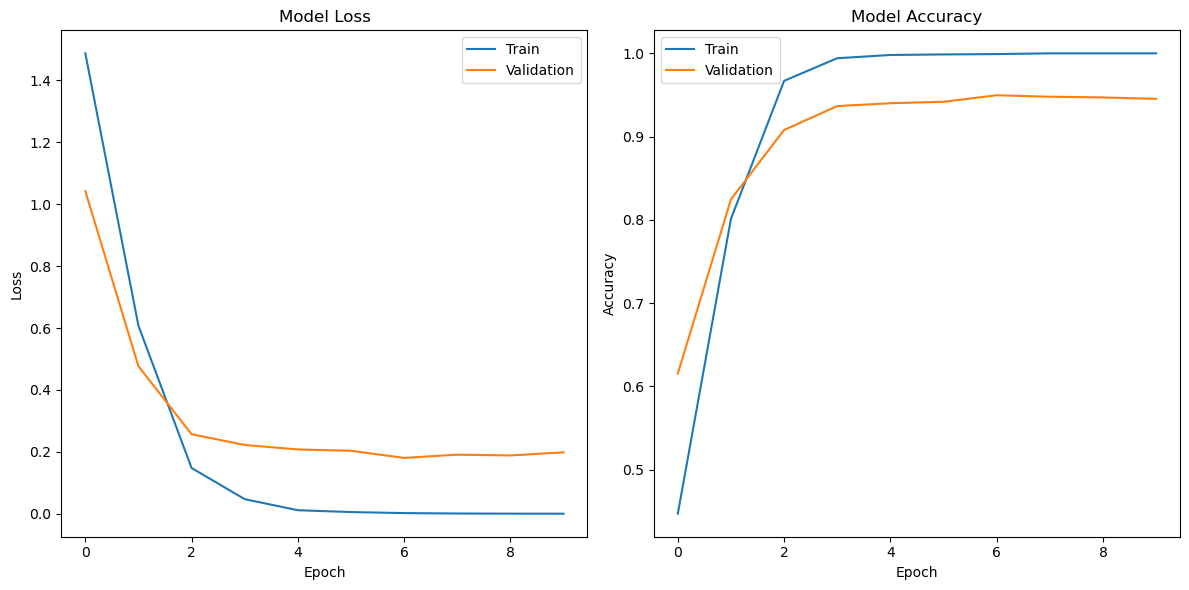

In [41]:
# Plot training & validation loss values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

plt.tight_layout()
plt.show()


## LONG SHORT TERM MEMORY

In [43]:
#LSTM model building

def build_lstm_model(input_shape, num_classes):
    model = Sequential()
    model.add(LSTM(units=128, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(units=64))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


In [44]:

input_shape = (X_train_lstm.shape[1], X_train_lstm.shape[2])
lstm_model = build_lstm_model(input_shape, num_classes)
lstm_model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 108, 128)       │        86,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 140,616 (549.28 KB)

 Trainable params: 140,616 (549.28 KB)

 Non-trainable params: 0 (0.00 B)

In [45]:
# Train the model
history = lstm_model.fit(X_train_lstm, Y_train_lstm, epochs=10, batch_size=32, validation_data=(X_test_lstm, Y_test_lstm))


Epoch 1/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 15s 224ms/step - accuracy: 0.1828 - loss: 2.0436 - val_accuracy: 0.3958 - val_loss: 1.7306
Epoch 2/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 0.3414 - loss: 1.7504 - val_accuracy: 0.4514 - val_loss: 1.5526
Epoch 3/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 0.4197 - loss: 1.5429 - val_accuracy: 0.4792 - val_loss: 1.4235
Epoch 4/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 151ms/step - accuracy: 0.4664 - loss: 1.4018 - val_accuracy: 0.5000 - val_loss: 1.4173
Epoch 5/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 0.5841 - loss: 1.1937 - val_accuracy: 0.5174 - val_loss: 1.3194
Epoch 6/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 0.6017 - loss: 1.0825 - val_accuracy: 0.5000 - val_loss: 1.3220
Epoch 7/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 0.6529 - loss: 1.0150 - val_accuracy: 0.5833 - val_loss: 1.2166
Epoch 8/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - accuracy: 0.6991 - loss: 0.8852 - val_accuracy: 0

In [46]:
# Evaluate the model
loss, accuracy = lstm_model.evaluate(X_test_lstm, Y_test_lstm)
print(f'LSTM Test Accuracy: {accuracy}')

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.5962 - loss: 1.3352
LSTM Test Accuracy: 0.6111111044883728
